# Import Modules

In [71]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory as ds_dic
from tensorflow.keras.layers import Layer,Dense,Embedding,MultiHeadAttention,LayerNormalization,Add,Flatten
from tensorflow.image import extract_patches
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Create a Dataset

In [87]:
train_dic = '/kaggle/input/indian-birds/Birds_25/train'
test_dic = '/kaggle/input/indian-birds/Birds_25/valid'
BATCH_SIZE = 32
IMG_SIZE = 256
CLASS_NAME = ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret',
              'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 
              'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 
              'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 
              'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 
              'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 
              'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 
              'White-Breasted-Waterhen', 'White-Wagtail']
N_CLASS = len(CLASS_NAME)

In [88]:
train_dataset = ds_dic(
    train_dic,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=99,
)

Found 30000 files belonging to 25 classes.


In [89]:
test_dataset = ds_dic(
    test_dic,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE,IMG_SIZE),
    shuffle=True,
    seed=99,
)

Found 7500 files belonging to 25 classes.


## Prefetch Dataset

In [62]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [90]:
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

## Normalize Dataset

In [91]:
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))

# Patch Embedding 

In [92]:
class PatchEncoder(Layer):
    def __init__(self,N_PATCH,HIDDEN_SIZE):
        super(PatchEncoder,self).__init__(name="PatchEncoder")
        
        self.linear_proj = Dense(HIDDEN_SIZE)
        self.embbed_layer = Embedding(N_PATCH,HIDDEN_SIZE)
        self.N_PATCH = N_PATCH
        
    def call(self,input):
        patch = extract_patches(images=input,sizes=[1, 16, 16, 1],strides=[1, 16, 16, 1],rates=[1, 1, 1, 1],
                                padding='VALID')
        patch = tf.reshape(patch,(tf.shape(patch)[0],256,patch.shape[-1]))
        embbed_input = tf.range(start=0,limit=self.N_PATCH , delta = 1)
        output = self.linear_proj(patch) + self.embbed_layer(embbed_input)
        return output

# Transformer Encoder

In [93]:
class TransformerEncoder(Layer):
  def __init__ (self,N_HEADS,HIDDEN_SIZE):
    super(TransformerEncoder,self).__init__(name="TransfomerEncoder")

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.mult_head_att = MultiHeadAttention(N_HEADS,HIDDEN_SIZE)

    self.dense_1 = Dense(HIDDEN_SIZE,activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE,activation = tf.nn.gelu)
    
  def call(self,input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.mult_head_att(x_1,x_1)

    x_1 = Add()([x_1,input])
    
    x_1 = self.layer_norm_2(x_1)
    
    x_2 = self.dense_1(x_1)
    x_2 = self.dense_2(x_2)
    output = Add()([x_2,x_1])

    return output

In [77]:
encoder = TransformerEncoder(8,768)
encoder(tf.zeros([1,256,768]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

# ViT Model

In [94]:
class ViT(Model):
  def __init__(self,N_HEADS,HIDDEN_SIZE,N_PATCHES,N_LAYERS,N_DENSE_UNITS):
    super(ViT,self).__init__(name="ViT")
    
    self.patch_encoder = PatchEncoder(N_PATCHES,HIDDEN_SIZE)
    
    self.trans_encoder = [TransformerEncoder(N_HEADS,HIDDEN_SIZE) for _ in range(N_LAYERS)]
    
    self.N_LAYERS = N_LAYERS
    
    self.dense_1 = Dense(N_DENSE_UNITS,activation =tf.nn.gelu )
    self.dense_2 = Dense(N_DENSE_UNITS,activation =tf.nn.gelu )
    self.dense_3 = Dense(N_CLASS, activation = 'softmax')
    
  def call(self,input,training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoder[i](x)

    x = Flatten()(x)
    
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [98]:
vit16  = ViT(N_HEADS = 4,HIDDEN_SIZE = 768,N_PATCHES = 256,N_LAYERS = 2 ,N_DENSE_UNITS=128)
a = vit16(tf.zeros([32,256,256,3]))

In [99]:
vit16.summary()

Model: "ViT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ PatchEncoder (PatchEncoder)     │ ?                      │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TransfomerEncoder               │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ TransfomerEncoder               │ ?                      │    10,631,424 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_131 (Dense)               │ ?                      │    25,165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ ?                      │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ ?                      │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,235,737 (180.19 MB)

 Trainable params: 47,235,737 (180.19 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [100]:
vit16.compile(
    optimizer = Adam(learning_rate=0.01),
    loss = CategoricalCrossentropy(),
    metrics = ['accuracy']
)

In [101]:
history = vit16.fit(
    train_dataset,
    epochs = 20,
    verbose = 1
)

Epoch 1/20


W0000 00:00:1709909744.557476     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.0404 - loss: 292.8914

W0000 00:00:1709910089.318071     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


938/938 ━━━━━━━━━━━━━━━━━━━━ 357s 368ms/step - accuracy: 0.0404 - loss: 292.4120
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 340s 362ms/step - accuracy: 0.0383 - loss: 3.2230
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 341s 363ms/step - accuracy: 0.0404 - loss: 3.2240
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 341s 362ms/step - accuracy: 0.0388 - loss: 3.2237
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 340s 362ms/step - accuracy: 0.0386 - loss: 3.2238
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 340s 361ms/step - accuracy: 0.0379 - loss: 3.2237
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 341s 362ms/step - accuracy: 0.0376 - loss: 3.2235
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 341s 363ms/step - accuracy: 0.0375 - loss: 3.2238
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 341s 362ms/step - accuracy: 0.0383 - loss: 3.2243
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 341s 362ms/step - accuracy: 0.0378 - loss: 3.2249
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 340s 362ms/step - accuracy: 0.0373 - loss: 3.2254
Epoch 12/20
938/9

# Visualizing

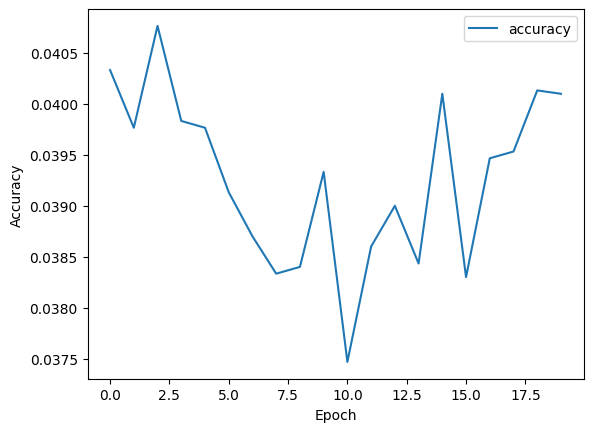

In [102]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

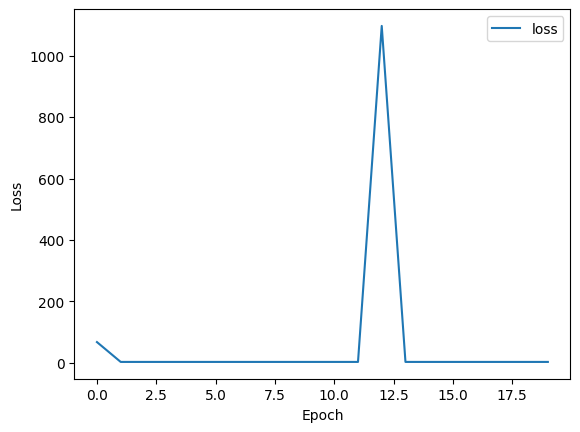

In [103]:
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()